## 참좋은여행 수익 및 수요 예측 모델링

- 자사 D.B 서버의 데이터를 활용한 예측 모델링을 진행
    - 예측 진행 데이터 후보 -> 총판매금액, 출발자수, 예약자수 (유럽 데이터를 샘플)
    - 2015~2018년 데이터를 트레이닝 시켜 2019년 데이터를 Prediction 할 예정
    

In [1]:
!pip install pymssql

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import norm, skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pymssql as mssql
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [109]:
# 그래프 그리기 위한 matplolib
%matplotlib inline
plt.style.use('ggplot')
#폰트깨짐방지
mpl.rcParams['axes.unicode_minus']=False

In [110]:
submission = pd.read_csv("submission.csv", parse_dates=["datetime"])

## STEP.1 데이터 탐색

#### 1. 출발자수를 예측하기 위한 변수 및 데이터 형태에 대해서 고민을 진행
    - 가공되지 않은 데이터 형태를 통해서 진행을 할 것인지 OR SQL에서 1차 가공을 통한 데이터를 통해 진행을 할 것인지
#### 1.1 가공되지 않은 데이터 예시
           - 출발일 : 2017-01-01, 고객넘버 : 2013444, 성별 : F, 생년월일 : 1991-01-25, 구매금액 : 142000, 여행기간 : 6
           - 출발일 : 2017-02-03, 고객넘버 : 2014464  성별 : M, 생년월일 : 1992-01-21. 구매금액  : 142.000, 여행기간 : 7
#### 1.2 SQL 1차 가공 데이터
            - 출발일 : 2017-01-01, 평균여행기간 : 4, 평균상품가 : 300,000, 행사개수 : 78개, 출발자수 : 38명, 출발자수, 예약자수
              항공 종류별 카운트수, 평균 페이크 카운트수 OR 총 페이크 카운트수, 평균맥스카운트, 평균민카운트, TC_YN_Y 카운트수,
              N 카운트수
              출발확정 행사 총합 카운트수, 상품타입별 카운트수, 회원가입자수?!, 비회원수 ?!, 해당년도에 직원수 카운트 가능?!


            - 2020년 데이터를 예측할시 미리 있어야지만 분석이 가능한 데이터? 의미가 있을지 없을지 고민 필요 
              딥러닝을 통해 아직까지 없는 데이터를 채워넣어서 분석 진행하는 방법을 해야될지? 추후 추가로 진행 고려
              10대 : 20, 20대 : 31, 30대 : 21, 40대, : 30 ... 80대 : 22 OR  평균 연령 : 34세, 남자 : 23, 여자 : 21,
              (평균판매금액, 총판매금액), 최저상품가, 최고상품가, 중간상품가), 항공종류별 카운트수?,
            - 월별로 가공하여 분석하는 것이 나을까? 그럼 평균값 데이터가 달라짐 1차적으로 DATETIME별로 진행해보고 2차로 월별로진행
            - 3차로 미래에 없는 데이터까지 채워서 예측 진행해볼 예정
            - 최종방안으로는 과거데이터를 이용하여 미래에 아예 아무 정보 없이 출발자수가 어떻게 변화될지 예측하는 방법
#### 우선적으로 KAGGLE에서 제공하는 데이터가 아닌 자사 데이터를 이용한 것이므로 1차적으로 SQL을 통해 가공하여 변수를
#### 설정하고 지속적으로 추가 및 제거 하는것이 맞다고 판단하여 진행
#### 또한, 가공되지 않은 데이터로 진행할 시 데이터 양이 많아 OVERFLOW가 날 확률이 높기에 1차 가공후 예측하는게 맞다고 판단
#### 2. 출발자수를 예측하는 방식
    - 주식 데이터와 같은 방식으로 과거에 기록된 데이터들만을 바탕으로 미래를 예측할 것인지
      ㄴ 2015~ 2018년 고객들에게 판매한 데이터 즉 연령, 성별, 전년도 판매금액 등을 중심으로 미래에 여행자수를 예상 및 예측하는 방법
    - 또는, KAGGLE 자전거 수요 및 레스토랑 예측과 같이 과거에 가지고 있던 Feature와 label을 토대로 미래의 Feature에 대입했을때
      나올 수 있는 label 예측값을 측정할 것인지
      ㄴ 2015~2018년에 고객들에게 판매한 데이터를 중심으로 상품들의 특성을 위주로 변수로 채택하여 추후 2019년 미래 상품들의
         특성을 변수를 추출하여 서로 비교해 출발자수를 예측하는 방식
         
#### 결론적으로 미래에 아직 없는 데이터들을 예측하여 그것을 바탕으로 출발자수를 측정하는 것 보다 과거에도 있는 변수와 미래에도
#### 공통으로 존재할 변수들을 중심으로 출발자수를 예측하는것이 맞을것으로 예상되어 진행
    - 해당 데이터를 최종 선정 후 출발일 및 출발자수를 통한 파생 변수를 탐색할 예정
    - EX) YEAR, MONTH, DAY, WEEK, WEEKDAY 등 데이터 시각화를 통해 연구 진행
    - https://bkshin.tistory.com/entry/%EC%BA%90%EA%B8%80-2-Predict-Future-Sales?category=1068294 (참고링크 파생변수 방법론)


In [111]:
##정답지
submission

,datetime,dep_count
0,2019-01-01,147
1,2019-01-02,284
2,2019-01-03,238
3,2019-01-04,222
4,2019-01-05,231
...,...,...
360,2019-12-27,412
361,2019-12-28,218
362,2019-12-29,485
363,2019-12-30,285


#### 1.2 SQL 1차 가공 데이터
#### 1차 변수 
        - 출발일(datetime), 평균여행기간, 평균페이크, 총페이크, 평균최대출발, 평균최소출발, 총최대출발, 총최소출발, 사용행사개수, 
          사용마스터개수, 출발확정상품개수, 브랜드타입 개수, 최고상품가, 최저상품가, 평균최고상품가, 평균최저상품가, 평균성인가,
          평균아동가 -> 파생변수 YEAR, MONTH, DAY, 하루전 출발자수, 2일전 출발자수, 3일전 출발자수, 4일전 출발자수 또는
          월별 한달전 출발자수 변동폭을 학습시키는 방법
#### 쿼리문
WITH LIST
AS (
SELECT PD.DEP_DATE, PD.TOUR_DAY, PD.FAKE_COUNT, PD.MAX_COUNT, PD.MIN_COUNT, PM.MASTER_CODE, PD.PRO_CODE, PD.DEP_CFM_YN,
(CASE WHEN PD.DEP_CFM_YN = 'Y' THEN 1 ELSE 0 END) AS CFM_DEP_CT, PDP.ADT_PRICE, PDP.CHD_PRICE, PM.LOW_PRICE, PM.HIGH_PRICE,
PM.AIRLINE
FROM PKG_MASTER PM
INNER JOIN PKG_DETAIL PD
	 ON PM.MASTER_CODE = PD.MASTER_CODE
INNER JOIN PKG_DETAIL_PRICE PDP
	on PD.pro_code = PDP.PRO_CODE
WHERE PD.DEP_DATE >= '2019-01-01' AND PD.DEP_DATE < '2019-02-01' 
AND PM.SIGN_CODE = 'E' --유럽만
AND PM.ATT_CODE = 'P' --패키지만
)
SELECT CONVERT(VARCHAR(10), DEP_DATE, 121), AVG(TOUR_DAY) AS 평균여행기간,
avg(FAKE_COUNT) AS 평균허수, sum(FAKE_COUNT) AS 총합허수, MAX(FAKE_COUNT) AS 최대허수, MIN(FAKE_COUNT) AS 최소허수,
AVG(MAX_COUNT) AS 평균최대출발인원, SUM(MAX_COUNT) AS SUM최대출인원, MAX(MAX_COUNT) AS MAX최대출인원, MIN(MAX_COUNT) AS MIN최대출인원,
AVG(ADT_PRICE) AS 성인평균상품가, AVG(CHD_PRICE) AS 아동평균상품가,MIN(ADT_PRICE) AS 성인최소상품가, 
AVG(LOW_PRICE) AS 평균최저상품가, AVG(HIGH_PRICE) AS 평균최고상품가, 
COUNT(PRO_CODE) AS 사용행사개수, COUNT(DISTINCT(MASTER_CODE)) AS 사용마스터개수, SUM(CFM_DEP_CT) AS 출발확정개수
FROM LIST
GROUP BY CONVERT(VARCHAR(10), DEP_DATE, 121)
ORDER BY CONVERT(VARCHAR(10), DEP_DATE, 121)
#### 2차 변수
        - 레스토랑 데이터와 동일하게 변수를 추출할시 국가별, 평균여행기간, 평균페이크, 총페이크, 평균최대출발, 평균 최소출발 ... 등
          위와 같은 변수를 선택하여 진행 하는 방법 1차변수에서 정확도가 높지 않을 경우 추가 진행예정
          (문제점 미래데이터에는 없는 국가가 생길수도 있음 고려해야됨) 또한 월별 예측이 아닌 국가별 출발자수 예측으로 진행됨
          목표랑 벗어날 수도 있음
#### 쿼리문  
WITH LIST AS(
SELECT I.KOR_NAME,
PD.DEP_DATE, PD.TOUR_DAY, PD.FAKE_COUNT, PD.MAX_COUNT, PD.MIN_COUNT, PM.MASTER_CODE, PD.PRO_CODE, PD.DEP_CFM_YN,
(CASE WHEN PD.DEP_CFM_YN = 'Y' THEN 1 ELSE 0 END) AS CFM_DEP_CT, PD.SHOW_YN,
(SELECT COUNT(RC.RES_CODE) FROM RES_MASTER RM INNER JOIN RES_CUSTOMER_DAMO RC
ON RM.RES_CODE = RC.RES_CODE
WHERE RM.RES_STATE < 7 AND RC.RES_STATE = 0 AND PD.PRO_CODE = RM.PRO_CODE) AS 출발자수
FROM PKG_MASTER PM
INNER JOIN PKG_DETAIL PD
	ON PM.MASTER_CODE = PD.MASTER_CODE
LEFT JOIN VIEW_CITY VC
	ON VC.REGION_CODE = PM.SIGN_CODE
LEFT join pro_trans_seat PTS
	on PD.SEAT_CODE = PTS.seat_code
LEFT JOIN PUB_AIRPORT PA  -- 공항정보 
	ON PTS.DEP_ARR_AIRPORT_CODE = PA.AIRPORT_CODE
LEFT JOIN PUB_CITY PC  -- 도시정보
		ON PA.CITY_CODE = PC.CITY_CODE
LEFT JOIN PUB_NATION I  -- 국가정보
		ON PC.NATION_CODE = I.NATION_CODE
WHERE PD.DEP_DATE >= '2019-01-01' AND PD.DEP_DATE < '2019-05-01' AND PM.SIGN_CODE = 'E' AND PD.PRO_TYPE = 1
)
SELECT CONVERT(VARCHAR(7), DEP_DATE, 121), KOR_NAME, AVG(TOUR_DAY) AS 평균여행기간, SUM(CFM_DEP_CT) AS 출발확정개수, SUM(출발자수)
FROM LIST
GROUP BY CONVERT(VARCHAR(7), DEP_DATE, 121), KOR_NAME
ORDER BY CONVERT(VARCHAR(7), DEP_DATE, 121)

## 최종 변수 추출 쿼리문
##### 추가적으로 year, month, day로 파생 변수를 설정한 후 상관관계 결과가 좋지 않다면
##### day-1, day-2. day-3,day-4,day-5,day-6,day-7
##### month-1, month-2, month-3 ...  형태로 lag기법을 사용하여 feature 변수를 추가할 예정
WITH LIST
AS (
SELECT PD.DEP_DATE, PD.TOUR_DAY, PD.FAKE_COUNT, PD.MAX_COUNT, PD.MIN_COUNT, PM.MASTER_CODE, PD.PRO_CODE, PD.DEP_CFM_YN,
(CASE WHEN PD.DEP_CFM_YN = 'Y' THEN 1 ELSE 0 END) AS CFM_DEP_CT, PDP.ADT_PRICE, PDP.CHD_PRICE, PDP.INF_PRICE,-- PM.LOW_PRICE, PM.HIGH_PRICE,-- 최저가 최고가 이상한 데이터가 많음 최저가 최고가가 똑같음 제외
(SELECT MAX(PDS.SHOP_SEQ) FROM PKG_DETAIL_SHOPPING PDS WHERE PDS.PRO_CODE = PD.PRO_CODE) AS 쇼핑횟수,
(SELECT MAX(PDO.OPT_SEQ) FROM PKG_DETAIL_OPTION PDO WHERE PDO.PRO_CODE = PD.PRO_CODE) AS 선택관광횟수, PTS.ARR_TRANS_CODE,
(CASE WHEN PM.BRAND_TYPE IN (2) THEN 1 END) AS 'LAR',
(CASE WHEN PM.BRAND_TYPE IN (1) THEN 1 END) AS 'LARPLUS',
(CASE WHEN PM.BRAND_TYPE IS NULL THEN 1 END) AS 'GENERAL',
(CASE WHEN PTS.ARR_TRANS_CODE = 'KE' THEN 1 ELSE 0 END) AS KE,
(CASE WHEN PTS.ARR_TRANS_CODE = 'OZ' THEN 1 ELSE 0 END) AS OZ,
(CASE WHEN PTS.ARR_TRANS_CODE = 'AY' THEN 1 ELSE 0 END) AS AY,
(CASE WHEN PTS.ARR_TRANS_CODE = 'AZ' THEN 1 ELSE 0 END) AS AZ,
(CASE WHEN PTS.ARR_TRANS_CODE = 'EK' THEN 1 ELSE 0 END) AS EK,
(CASE WHEN PTS.ARR_TRANS_CODE = 'TK' THEN 1 ELSE 0 END) AS TK,
(CASE WHEN PTS.ARR_TRANS_CODE = 'LH' THEN 1 ELSE 0 END) AS LH,
(CASE WHEN PTS.ARR_TRANS_CODE = 'AF' THEN 1 ELSE 0 END) AS AF,
(CASE WHEN PTS.ARR_TRANS_CODE = 'BA' THEN 1 ELSE 0 END) AS BA,
(CASE WHEN PTS.ARR_TRANS_CODE = 'EY' THEN 1 ELSE 0 END) AS EY,
(CASE WHEN PTS.ARR_TRANS_CODE = 'QR' THEN 1 ELSE 0 END) AS QR,
(CASE WHEN PTS.ARR_TRANS_CODE = 'SU' THEN 1 ELSE 0 END) AS SU,
(CASE WHEN PTS.ARR_TRANS_CODE = 'ZE' THEN 1 ELSE 0 END) AS ZE,
(CASE WHEN PTS.ARR_TRANS_CODE = 'TW' THEN 1 ELSE 0 END) AS TW,
(CASE WHEN PTS.ARR_TRANS_CODE = 'KA' THEN 1 ELSE 0 END) AS KA,
(CASE WHEN PTS.ARR_TRANS_CODE = 'BX' THEN 1 ELSE 0 END) AS BX,
(CASE WHEN PTS.ARR_TRANS_CODE = 'KL' THEN 1 ELSE 0 END) AS KL,
(CASE WHEN PTS.ARR_TRANS_CODE = 'R3' THEN 1 ELSE 0 END) AS R3,
(CASE WHEN PTS.ARR_TRANS_CODE = '3P' THEN 1 ELSE 0 END) AS AR,
(CASE WHEN PTS.ARR_TRANS_CODE = 'CX' THEN 1 ELSE 0 END) AS CX,
(CASE WHEN PTS.ARR_TRANS_CODE = 'OK' THEN 1 ELSE 0 END) AS OK,
(CASE WHEN PTS.ARR_TRANS_CODE = 'LO' THEN 1 ELSE 0 END) AS LO,
(CASE WHEN PTS.ARR_TRANS_CODE = 'CA' THEN 1 ELSE 0 END) AS CA,
(CASE WHEN PTS.ARR_TRANS_CODE = 'HY' THEN 1 ELSE 0 END) AS HY,
(CASE WHEN PTS.ARR_TRANS_CODE = 'VN' THEN 1 ELSE 0 END) AS VN,
(CASE WHEN PTS.ARR_TRANS_CODE = 'SQ' THEN 1 ELSE 0 END) AS SQ,
(CASE WHEN PTS.ARR_TRANS_CODE = '7C' THEN 1 ELSE 0 END) AS JE,
(CASE WHEN PTS.ARR_TRANS_CODE = 'OS' THEN 1 ELSE 0 END) AS OS,
(CASE WHEN PTS.ARR_TRANS_CODE = 'DB' THEN 1 ELSE 0 END) AS DB
--PA.KOR_NAME --항공편 이름 필요할떄,
FROM PKG_MASTER PM
INNER JOIN PKG_DETAIL PD
	 ON PM.MASTER_CODE = PD.MASTER_CODE
INNER JOIN PKG_DETAIL_PRICE PDP
	on PD.pro_code = PDP.PRO_CODE
LEFT JOIN PRO_TRANS_SEAT PTS
	ON PD.SEAT_CODE = PTS.SEAT_CODE
--LEFT JOIN PUB_AIRLINE PA
--	ON PTS.ARR_TRANS_CODE = PA.AIRLINE_CODE -- 항공편 이름 불러오는 테이블
WHERE PD.DEP_DATE >= '2019-01-01' AND PD.DEP_DATE < '2020-01-01'  AND PTS.ARR_TRANS_CODE IS NOT NULL AND PD.SHOW_YN = 'Y'
AND PM.SIGN_CODE = 'E' --유럽만
AND PM.ATT_CODE = 'P' --패키지만
AND PM.MASTER_CODE LIKE 'EPP%'
)
SELECT CONVERT(VARCHAR(10), DEP_DATE, 121) AS DATETIME , AVG(TOUR_DAY) AS 평균여행기간,
SUM(LAR) AS LAR, SUM(LARPLUS) AS LARPLUS, SUM(GENERAL) AS GEN,
avg(FAKE_COUNT) AS 평균허수, sum(FAKE_COUNT) AS 총합허수, MAX(FAKE_COUNT) AS 최대허수, MIN(FAKE_COUNT) AS 최소허수,
AVG(MAX_COUNT) AS 평균최대출발인원, SUM(MAX_COUNT) AS SUM최대출인원, MAX(MAX_COUNT) AS MAX최대출인원, MIN(MAX_COUNT) AS MIN최대출인원,
AVG(MIN_COUNT) AS 평균최소출발인,SUM(MIN_COUNT) AS SUM최소출발인, MAX(MIN_COUNT) AS MAX최소출인원, MIN(MIN_COUNT) AS MIN최소출발인원,
AVG(ADT_PRICE) AS 성인평균상품가, MIN(ADT_PRICE) AS 성인최소상품가, MAX(ADT_PRICE) AS 성인최대상품가,
AVG(NULLIF(CHD_PRICE,0)) AS 아동평균상품가, MIN(NULLIF(CHD_PRICE,0)) AS 아동최저상품가, MAX(NULLIF(CHD_PRICE,0)) AS 아동최대상품가, -- 패키지로 분류된 상품중 EPF가 포함되서 CHD, INF 값 0 제거
AVG(NULLIF(INF_PRICE,0)) AS 유아평균상품가, MIN(NULLIF(INF_PRICE,0)) AS 유아최저상품가, MAX(NULLIF(INF_PRICE,0)) AS 유아최대상품가,
COUNT(PRO_CODE) AS 사용행사개수, COUNT(DISTINCT(MASTER_CODE)) AS 사용마스터개수, SUM(CFM_DEP_CT) AS 출발확정개수,
SUM(쇼핑횟수) AS 총쇼핑횟수, AVG(쇼핑횟수) AS 평균쇼핑횟수, MAX(쇼핑횟수) AS 최대쇼핑횟수, MIN(쇼핑횟수) AS 최저쇼핑횟수,
SUM(선택관광횟수) AS 총선택관광횟수, AVG(선택관광횟수) AS 평균선택관광횟수, MAX(선택관광횟수) AS 최대선택관광횟수, MIN(선택관광횟수) AS 최소선택관광횟수,
SUM(KE) AS KE, SUM(OZ) AS OZ, SUM(AY) AS AY, SUM(AZ) AS AZ, SUM(EK) AS EK, SUM(TK) AS TK, SUM(LH) AS LH, SUM(AF) AS AF,
SUM(BA) AS BA, SUM(EY) AS EY, SUM(QR) AS QR, SUM(SU) AS SU, SUM(ZE) AS ZE, SUM(TW) AS TW, SUM(KA) AS KA, SUM(BX) AS BX,
SUM(KL) AS KL, SUM(R3) AS R3, SUM(AR) AS AR, SUM(CX) AS CX, SUM(OK) AS OK, SUM(LO) AS LO, SUM(CA) AS CA, SUM(HY) AS HY, 
SUM(VN) AS VN, SUM(SQ) AS SQ, SUM(JE) AS JE, SUM(OS) AS OS, SUM(DB) AS DB,
SUM(KE+OZ) AS 국적기, SUM(TW+ZE+JE) AS 저가항공, SUM(AY+AZ+EK+TK+LH+AF+BA+EY+QR+SU+KA+BX+KL+R3+AR+CX+OK+LO+CA+HY+VN+SQ+OS+DB) AS 외항사
FROM LIST
GROUP BY CONVERT(VARCHAR(10), DEP_DATE, 121)
ORDER BY CONVERT(VARCHAR(10), DEP_DATE, 121)

#### 추출된 train data 형태 및 정보

In [112]:
train = pd.read_csv("train_1.csv", parse_dates=["datetime"])

In [113]:
train

,datetime,tourday,b1,b2,b3,f1,f2,f3,f4,x1,...,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3,count
0,2015-01-01,9,3,13,117,3,487,30,0,0,...,0,0,0,0,0,0,63,0,70,321
1,2015-01-02,9,3,2,87,3,314,27,-1,0,...,2,0,0,0,0,0,49,0,43,271
2,2015-01-03,8,1,5,94,3,301,14,-1,0,...,0,0,0,0,0,0,48,0,52,315
3,2015-01-04,9,3,3,93,4,400,24,0,0,...,0,0,0,0,1,0,44,0,55,271
4,2015-01-05,10,4,6,58,3,208,20,0,1,...,0,0,0,0,0,0,41,0,27,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2018-12-27,9,8,1,125,4,623,27,0,0,...,0,0,0,0,0,0,80,1,53,241
1457,2018-12-28,9,3,5,105,3,419,22,-1,0,...,1,0,0,0,0,0,45,3,65,273
1458,2018-12-29,9,8,5,121,4,604,33,-1,0,...,0,0,0,0,0,0,77,1,56,381
1459,2018-12-30,9,8,3,108,4,478,26,-2,0,...,0,0,0,0,1,0,57,2,60,250


In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 56 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  1461 non-null   datetime64[ns]
 1   tourday   1461 non-null   int64         
 2   b1        1461 non-null   int64         
 3   b2        1461 non-null   int64         
 4   b3        1461 non-null   int64         
 5   f1        1461 non-null   int64         
 6   f2        1461 non-null   int64         
 7   f3        1461 non-null   int64         
 8   f4        1461 non-null   int64         
 9   x1        1461 non-null   int64         
 10  x2        1461 non-null   int64         
 11  n1        1461 non-null   int64         
 12  n2        1461 non-null   int64         
 13  p1        1461 non-null   int64         
 14  p2        1461 non-null   int64         
 15  p3        1461 non-null   int64         
 16  up1       1461 non-null   int64         
 17  um1       1461

In [115]:
##결측치 체크
train.columns[train.isna().any()].tolist()

[]

#### test 데이터 형태 및 정보

In [116]:
test = pd.read_csv("test.csv", parse_dates=["datetime"])

In [117]:
test.head()

,datetime,tourday,b1,b2,b3,f1,f2,f3,f4,x1,...,ar23,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3
0,2019-01-01,9,8,3,121,4,581,26,-1,1,...,0,0,0,0,0,0,0,68,1,63
1,2019-01-02,9,10,4,128,4,587,34,-2,0,...,0,1,0,0,0,0,0,68,2,72
2,2019-01-03,9,10,4,121,2,399,13,0,0,...,0,0,0,0,0,0,0,78,1,56
3,2019-01-04,9,2,4,94,3,344,28,0,0,...,0,1,0,0,0,0,0,42,3,55
4,2019-01-05,9,6,1,103,2,307,15,0,0,...,0,0,0,0,0,0,0,61,1,48


In [118]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 55 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  365 non-null    datetime64[ns]
 1   tourday   365 non-null    int64         
 2   b1        365 non-null    int64         
 3   b2        365 non-null    int64         
 4   b3        365 non-null    int64         
 5   f1        365 non-null    int64         
 6   f2        365 non-null    int64         
 7   f3        365 non-null    int64         
 8   f4        365 non-null    int64         
 9   x1        365 non-null    int64         
 10  x2        365 non-null    int64         
 11  n1        365 non-null    int64         
 12  n2        365 non-null    int64         
 13  p1        365 non-null    int64         
 14  p2        365 non-null    int64         
 15  p3        365 non-null    int64         
 16  up1       365 non-null    int64         
 17  um1       365 no

In [119]:
##결측치 체크
test.columns[test.isna().any()].tolist()

[]

In [120]:
train.describe()

,tourday,b1,b2,b3,f1,f2,f3,f4,x1,x2,...,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3,count
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,...,1461.000000,1461.0,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,9.108830,6.937714,3.305270,116.491444,3.157426,466.329911,22.902122,-3.051335,0.184805,62.965092,...,0.633128,0.0,0.000684,0.232717,0.139630,0.077344,67.850103,0.546886,58.337440,262.486653
std,0.369835,3.627268,3.351737,25.207592,0.895113,156.369594,11.798799,6.486612,0.434869,62.318840,...,1.237363,0.0,0.026162,0.628586,0.346722,0.272306,18.942707,1.169837,12.436597,114.533566
min,8.000000,0.000000,0.000000,43.000000,1.000000,118.000000,9.000000,-65.000000,0.000000,-6.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,20.000000,12.000000
25%,9.000000,4.000000,1.000000,100.000000,3.000000,350.000000,19.000000,-2.000000,0.000000,20.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,53.000000,0.000000,51.000000,180.000000
50%,9.000000,7.000000,2.000000,119.000000,3.000000,463.000000,22.000000,-1.000000,0.000000,45.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,67.000000,0.000000,59.000000,251.000000
75%,9.000000,9.000000,5.000000,136.000000,4.000000,571.000000,26.000000,0.000000,0.000000,93.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,81.000000,0.000000,67.000000,336.000000
max,10.000000,21.000000,26.000000,172.000000,6.000000,979.000000,412.000000,0.000000,2.000000,329.000000,...,6.000000,0.0,1.000000,4.000000,1.000000,2.000000,119.000000,5.000000,101.000000,1036.000000


In [121]:
test.describe()

,tourday,b1,b2,b3,f1,f2,f3,f4,x1,x2,...,ar23,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.0,365.0,365.0,365.0,365.0,365.000000,365.000000,365.000000
mean,9.084932,9.005479,3.643836,97.726027,3.063014,405.287671,23.501370,-3.901370,0.383562,86.600000,...,0.134247,0.791781,0.0,0.0,0.0,0.0,0.0,53.961644,1.758904,54.652055
std,0.364523,3.724728,2.995280,27.329120,0.979951,170.275656,5.934452,6.378718,0.651080,56.749149,...,0.349340,1.251565,0.0,0.0,0.0,0.0,0.0,16.792812,1.273983,15.753319
min,8.000000,1.000000,0.000000,28.000000,0.000000,-1.000000,9.000000,-41.000000,0.000000,-5.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,14.000000,0.000000,16.000000
25%,9.000000,6.000000,1.000000,79.000000,2.000000,301.000000,20.000000,-4.000000,0.000000,47.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,42.000000,1.000000,44.000000
50%,9.000000,9.000000,3.000000,99.000000,3.000000,399.000000,23.000000,-1.000000,0.000000,84.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,55.000000,2.000000,56.000000
75%,9.000000,11.000000,5.000000,119.000000,4.000000,518.000000,27.000000,0.000000,1.000000,116.000000,...,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,66.000000,3.000000,65.000000
max,10.000000,18.000000,20.000000,155.000000,5.000000,912.000000,43.000000,0.000000,4.000000,303.000000,...,2.000000,4.000000,0.0,0.0,0.0,0.0,0.0,96.000000,5.000000,92.000000


In [122]:
train.columns

Index(['datetime', 'tourday', 'b1', 'b2', 'b3', 'f1', 'f2', 'f3', 'f4', 'x1',
       'x2', 'n1', 'n2', 'p1', 'p2', 'p3', 'up1', 'um1', 'uc1', 's1', 's2',
       'o1', 'o2', 'ar1', 'ar2', 'ar3', 'ar4', 'ar5', 'ar6', 'ar7', 'ar8',
       'ar9', 'ar10', 'ar11', 'ar12', 'ar13', 'ar14', 'ar15', 'ar16', 'ar17',
       'ar18', 'ar19', 'ar20', 'ar21', 'ar22', 'ar23', 'ar24', 'ar25', 'ar26',
       'ar27', 'ar28', 'ar29', 'art1', 'art2', 'art3', 'count'],
      dtype='object')

In [123]:
X_train = train[features]

In [124]:
X_train

,tourday,b1,b2,b3,f1,f2,f3,f4,x1,x2,...,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3,count
0,9,3,13,117,3,487,30,0,0,4,...,0,0,0,0,0,0,63,0,70,321
1,9,3,2,87,3,314,27,-1,0,65,...,2,0,0,0,0,0,49,0,43,271
2,8,1,5,94,3,301,14,-1,0,38,...,0,0,0,0,0,0,48,0,52,315
3,9,3,3,93,4,400,24,0,0,36,...,0,0,0,0,1,0,44,0,55,271
4,10,4,6,58,3,208,20,0,1,110,...,0,0,0,0,0,0,41,0,27,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,9,8,1,125,4,623,27,0,0,20,...,0,0,0,0,0,0,80,1,53,241
1457,9,3,5,105,3,419,22,-1,0,35,...,1,0,0,0,0,0,45,3,65,273
1458,9,8,5,121,4,604,33,-1,0,19,...,0,0,0,0,0,0,77,1,56,381
1459,9,8,3,108,4,478,26,-2,0,29,...,0,0,0,0,1,0,57,2,60,250


In [125]:
## 기본 스케일, 평균과 표준편차를 사용한 정규화
scaler = StandardScaler()
X_train[:] = scaler.fit_transform(X_train[:])

In [79]:
X_train

,tourday,b1,b2,b3,f1,f2,f3,f4,x1,x2,...,ar23,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3
0,-0.294366,-1.085958,2.893439,0.020182,-0.175933,0.132233,0.601782,0.470566,-0.425112,-0.946508,...,-0.297406,-0.511851,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-0.256128,-0.467649,0.938082
1,-0.294366,-1.085958,-0.389564,-1.170344,-0.175933,-0.974499,0.347432,0.316350,-0.425112,0.032664,...,-0.297406,1.105044,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-0.995452,-0.467649,-1.233673
2,-2.999198,-1.637526,0.505800,-0.892554,-0.175933,-1.057664,-0.754752,0.316350,-0.425112,-0.400740,...,-0.297406,-0.511851,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-1.048261,-0.467649,-0.509754
3,-0.294366,-1.085958,-0.091109,-0.932238,0.941626,-0.424332,0.093082,0.470566,-0.425112,-0.432844,...,-0.297406,-0.511851,0.0,-0.026171,-0.37035,2.482290,-0.284131,-1.259496,-0.467649,-0.268448
4,2.410466,-0.810174,0.804255,-2.321184,-0.175933,-1.652613,-0.246052,0.470566,1.875216,0.755005,...,-0.297406,-0.511851,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-1.417923,-0.467649,-2.520639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,-0.294366,0.292961,-0.688019,0.337655,0.941626,1.002265,0.347432,0.470566,-0.425112,-0.689676,...,-0.297406,-0.511851,0.0,-0.026171,-0.37035,-0.402854,-0.284131,0.641622,0.387464,-0.429319
1457,-0.294366,-1.085958,0.505800,-0.456028,-0.175933,-0.302783,-0.076485,0.316350,-0.425112,-0.448896,...,-0.297406,0.296597,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-1.206687,2.097688,0.535906
1458,-0.294366,0.292961,0.505800,0.178918,0.941626,0.880716,0.856133,0.316350,-0.425112,-0.705728,...,-0.297406,-0.511851,0.0,-0.026171,-0.37035,-0.402854,-0.284131,0.483195,0.387464,-0.188013
1459,-0.294366,0.292961,-0.091109,-0.336976,0.941626,0.074657,0.262649,0.162133,-0.425112,-0.545208,...,-0.297406,-0.511851,0.0,-0.026171,-0.37035,2.482290,-0.284131,-0.572981,1.242576,0.133729


In [126]:
train.iloc[:,1:-1]

,tourday,b1,b2,b3,f1,f2,f3,f4,x1,x2,...,ar23,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3
0,9,3,13,117,3,487,30,0,0,4,...,0,0,0,0,0,0,0,63,0,70
1,9,3,2,87,3,314,27,-1,0,65,...,0,2,0,0,0,0,0,49,0,43
2,8,1,5,94,3,301,14,-1,0,38,...,0,0,0,0,0,0,0,48,0,52
3,9,3,3,93,4,400,24,0,0,36,...,0,0,0,0,0,1,0,44,0,55
4,10,4,6,58,3,208,20,0,1,110,...,0,0,0,0,0,0,0,41,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,9,8,1,125,4,623,27,0,0,20,...,0,0,0,0,0,0,0,80,1,53
1457,9,3,5,105,3,419,22,-1,0,35,...,0,1,0,0,0,0,0,45,3,65
1458,9,8,5,121,4,604,33,-1,0,19,...,0,0,0,0,0,0,0,77,1,56
1459,9,8,3,108,4,478,26,-2,0,29,...,0,0,0,0,0,1,0,57,2,60


In [127]:
## 트레인과 테스트 데이터를 복사하여 정규화 진행 에정
X_train = train.copy()
X_test = test.copy()

In [128]:
X_train.head()

,datetime,tourday,b1,b2,b3,f1,f2,f3,f4,x1,...,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3,count
0,2015-01-01,9,3,13,117,3,487,30,0,0,...,0,0,0,0,0,0,63,0,70,321
1,2015-01-02,9,3,2,87,3,314,27,-1,0,...,2,0,0,0,0,0,49,0,43,271
2,2015-01-03,8,1,5,94,3,301,14,-1,0,...,0,0,0,0,0,0,48,0,52,315
3,2015-01-04,9,3,3,93,4,400,24,0,0,...,0,0,0,0,1,0,44,0,55,271
4,2015-01-05,10,4,6,58,3,208,20,0,1,...,0,0,0,0,0,0,41,0,27,109


In [129]:
X_test.head()

,datetime,tourday,b1,b2,b3,f1,f2,f3,f4,x1,...,ar23,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3
0,2019-01-01,9,8,3,121,4,581,26,-1,1,...,0,0,0,0,0,0,0,68,1,63
1,2019-01-02,9,10,4,128,4,587,34,-2,0,...,0,1,0,0,0,0,0,68,2,72
2,2019-01-03,9,10,4,121,2,399,13,0,0,...,0,0,0,0,0,0,0,78,1,56
3,2019-01-04,9,2,4,94,3,344,28,0,0,...,0,1,0,0,0,0,0,42,3,55
4,2019-01-05,9,6,1,103,2,307,15,0,0,...,0,0,0,0,0,0,0,61,1,48


In [131]:
## datetime과 count를 제외하고 해당 feature들만 정규화 하기위해 iloc을 사용
fit_train = scaler.fit_transform(X_train.iloc[:,1:-1])

In [132]:
## 정규화된 값들의 array
fit_train

array([[-0.29436572, -1.08595827,  2.89343946, ..., -0.2561283 ,
        -0.46764873,  0.93808247],
       [-0.29436572, -1.08595827, -0.38956432, ..., -0.99545208,
        -0.46764873, -1.23367287],
       [-2.99919785, -1.63752615,  0.50580035, ..., -1.04826093,
        -0.46764873, -0.50975442],
       ...,
       [-0.29436572,  0.29296145,  0.50580035, ...,  0.48319548,
         0.38746366, -0.18801289],
       [-0.29436572,  0.29296145, -0.09110943, ..., -0.57298135,
         1.24257605,  0.13372864],
       [ 2.41046642,  0.84452934, -0.68801921, ..., -1.57634934,
         0.38746366, -0.34888366]])

In [135]:
## 정규화된 array 값들을 기존의 데이터에서 정규화 데이터로 교체 진행
X_train.iloc[:,1:-1] = fit_train

In [136]:
## 데이터 확인 iloc의 경우 앞의 index 정수를 중심
X_train.head()

,datetime,tourday,b1,b2,b3,f1,f2,f3,f4,x1,...,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3,count
0,2015-01-01,-0.294366,-1.085958,2.893439,0.020182,-0.175933,0.132233,0.601782,0.470566,-0.425112,...,-0.511851,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-0.256128,-0.467649,0.938082,321
1,2015-01-02,-0.294366,-1.085958,-0.389564,-1.170344,-0.175933,-0.974499,0.347432,0.316350,-0.425112,...,1.105044,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-0.995452,-0.467649,-1.233673,271
2,2015-01-03,-2.999198,-1.637526,0.505800,-0.892554,-0.175933,-1.057664,-0.754752,0.316350,-0.425112,...,-0.511851,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-1.048261,-0.467649,-0.509754,315
3,2015-01-04,-0.294366,-1.085958,-0.091109,-0.932238,0.941626,-0.424332,0.093082,0.470566,-0.425112,...,-0.511851,0.0,-0.026171,-0.37035,2.482290,-0.284131,-1.259496,-0.467649,-0.268448,271
4,2015-01-05,2.410466,-0.810174,0.804255,-2.321184,-0.175933,-1.652613,-0.246052,0.470566,1.875216,...,-0.511851,0.0,-0.026171,-0.37035,-0.402854,-0.284131,-1.417923,-0.467649,-2.520639,109


In [ ]:
## test도 똑같이 맞춰주고 minmaxscaler가 맞을지 standard가 맞을지 생각해봐야될 정규화 문제
## 둘다 out lier에 민감할 수 있기에 outlier 제거 여부도 고려해야될 대상


In [38]:
features = train.select_dtypes([np.number]).columns.tolist()
train[features]

,tourday,b1,b2,b3,f1,f2,f3,f4,x1,x2,...,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3,count
0,9,3,13,117,3,487,30,0,0,4,...,0,0,0,0,0,0,63,0,70,321
1,9,3,2,87,3,314,27,-1,0,65,...,2,0,0,0,0,0,49,0,43,271
2,8,1,5,94,3,301,14,-1,0,38,...,0,0,0,0,0,0,48,0,52,315
3,9,3,3,93,4,400,24,0,0,36,...,0,0,0,0,1,0,44,0,55,271
4,10,4,6,58,3,208,20,0,1,110,...,0,0,0,0,0,0,41,0,27,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,9,8,1,125,4,623,27,0,0,20,...,0,0,0,0,0,0,80,1,53,241
1457,9,3,5,105,3,419,22,-1,0,35,...,1,0,0,0,0,0,45,3,65,273
1458,9,8,5,121,4,604,33,-1,0,19,...,0,0,0,0,0,0,77,1,56,381
1459,9,8,3,108,4,478,26,-2,0,29,...,0,0,0,0,1,0,57,2,60,250


count    1461.000000
mean      262.486653
std       114.533566
min        12.000000
25%       180.000000
50%       251.000000
75%       336.000000
max      1036.000000
Name: count, dtype: float64


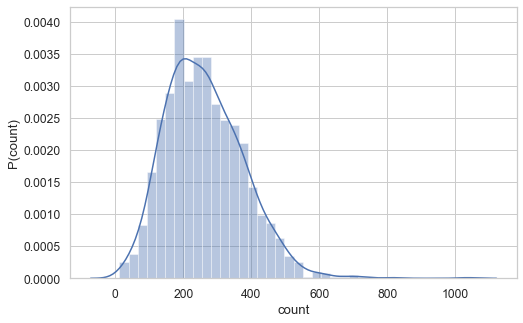

In [25]:
print(train['count'].describe())
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    train['count'], norm_hist=False, kde=True
).set(xlabel='count', ylabel='P(count)');

## 위 그래프 분석
- 위에서 보여지는 데이터를 봣을때 왜도가 살짝 왼쪽으로 치우쳐져 있지만 거의 정규분포를 그리고 있음
- 800 이상으로 가지는 값들은 아웃라이어 제거해야 될 가능성

In [26]:
##### sns.pairplot(train[['tourday', 'b1', 'b2', 'b3', 'f1', 'f2', 'f3', 'f4', 'x1',
       'x2', 'n1', 'n2', 'p1', 'p2', 'p3', 'up1', 'um1', 'uc1', 's1', 's2',
       'o1', 'o2', 'ar1', 'ar2', 'ar3', 'ar4', 'ar5', 'ar6', 'ar7', 'ar8',
       'ar9', 'ar10', 'ar11', 'ar12', 'ar13', 'ar14', 'ar15', 'ar16', 'ar17',
       'ar18', 'ar19', 'ar20', 'ar21', 'ar22', 'ar23', 'ar24', 'ar25', 'ar26',
       'ar27', 'ar28', 'ar29', 'art1', 'art2', 'art3']])

IndentationError: unexpected indent (<ipython-input-26-a13047e18271>, line 2)

In [27]:
train[features].corr(method = 'pearson')

,tourday,b1,b2,b3,f1,f2,f3,f4,x1,x2,...,ar24,ar25,ar26,ar27,ar28,ar29,art1,art2,art3,count
tourday,1.000000,0.110235,-0.150590,-0.313799,-0.107652,-0.246792,-0.016393,-0.084179,-0.048481,-0.149376,...,-0.069848,NaN,-0.078493,0.147308,-0.204049,-0.124445,-0.296547,0.034900,-0.196069,-0.106291
b1,0.110235,1.000000,-0.057308,0.515359,-0.044865,0.363389,0.141701,-0.054514,-0.288835,-0.254233,...,-0.151138,NaN,-0.042856,0.092277,-0.147749,-0.165706,0.582726,0.204474,0.413983,0.190341
b2,-0.150590,-0.057308,1.000000,0.066879,0.065929,0.162461,0.114304,-0.029270,0.011079,0.040040,...,0.111745,NaN,0.005426,-0.044796,-0.146329,-0.196238,0.153283,0.006129,0.154299,0.205000
b3,-0.313799,0.515359,0.066879,1.000000,0.154084,0.744495,0.130961,0.002513,-0.137379,0.072018,...,-0.093538,NaN,-0.029591,-0.153026,0.009227,-0.045554,0.904879,0.024559,0.814653,0.388988
f1,-0.107652,-0.044865,0.065929,0.154084,1.000000,0.717946,0.182725,0.146961,0.051899,0.081543,...,-0.071500,NaN,-0.063100,-0.118719,0.057126,0.048363,0.147420,-0.094703,0.101359,-0.049058
f2,-0.246792,0.363389,0.162461,0.744495,0.717946,1.000000,0.240028,0.095307,-0.071415,0.076934,...,-0.128536,NaN,-0.048776,-0.168343,0.012061,-0.030696,0.699223,-0.036955,0.597239,0.212756
f3,-0.016393,0.141701,0.114304,0.130961,0.182725,0.240028,1.000000,-0.018922,-0.048133,-0.037217,...,-0.000725,NaN,-0.017534,0.068920,-0.042700,-0.062450,0.104273,0.098165,0.169520,0.165525
f4,-0.084179,-0.054514,-0.029270,0.002513,0.146961,0.095307,-0.018922,1.000000,-0.020430,-0.020467,...,0.029653,NaN,-0.003829,-0.085091,0.074757,0.077864,-0.002393,-0.050365,-0.010313,-0.251929
x1,-0.048481,-0.288835,0.011079,-0.137379,0.051899,-0.071415,-0.048133,-0.020430,1.000000,0.782080,...,0.177002,NaN,-0.011126,-0.129878,-0.098576,-0.039811,-0.123767,-0.166490,-0.155533,-0.057982
x2,-0.149376,-0.254233,0.040040,0.072018,0.081543,0.076934,-0.037217,-0.020467,0.782080,1.000000,...,0.189198,NaN,-0.016789,-0.205048,-0.141850,-0.076246,0.071884,-0.143145,-0.013412,0.043014


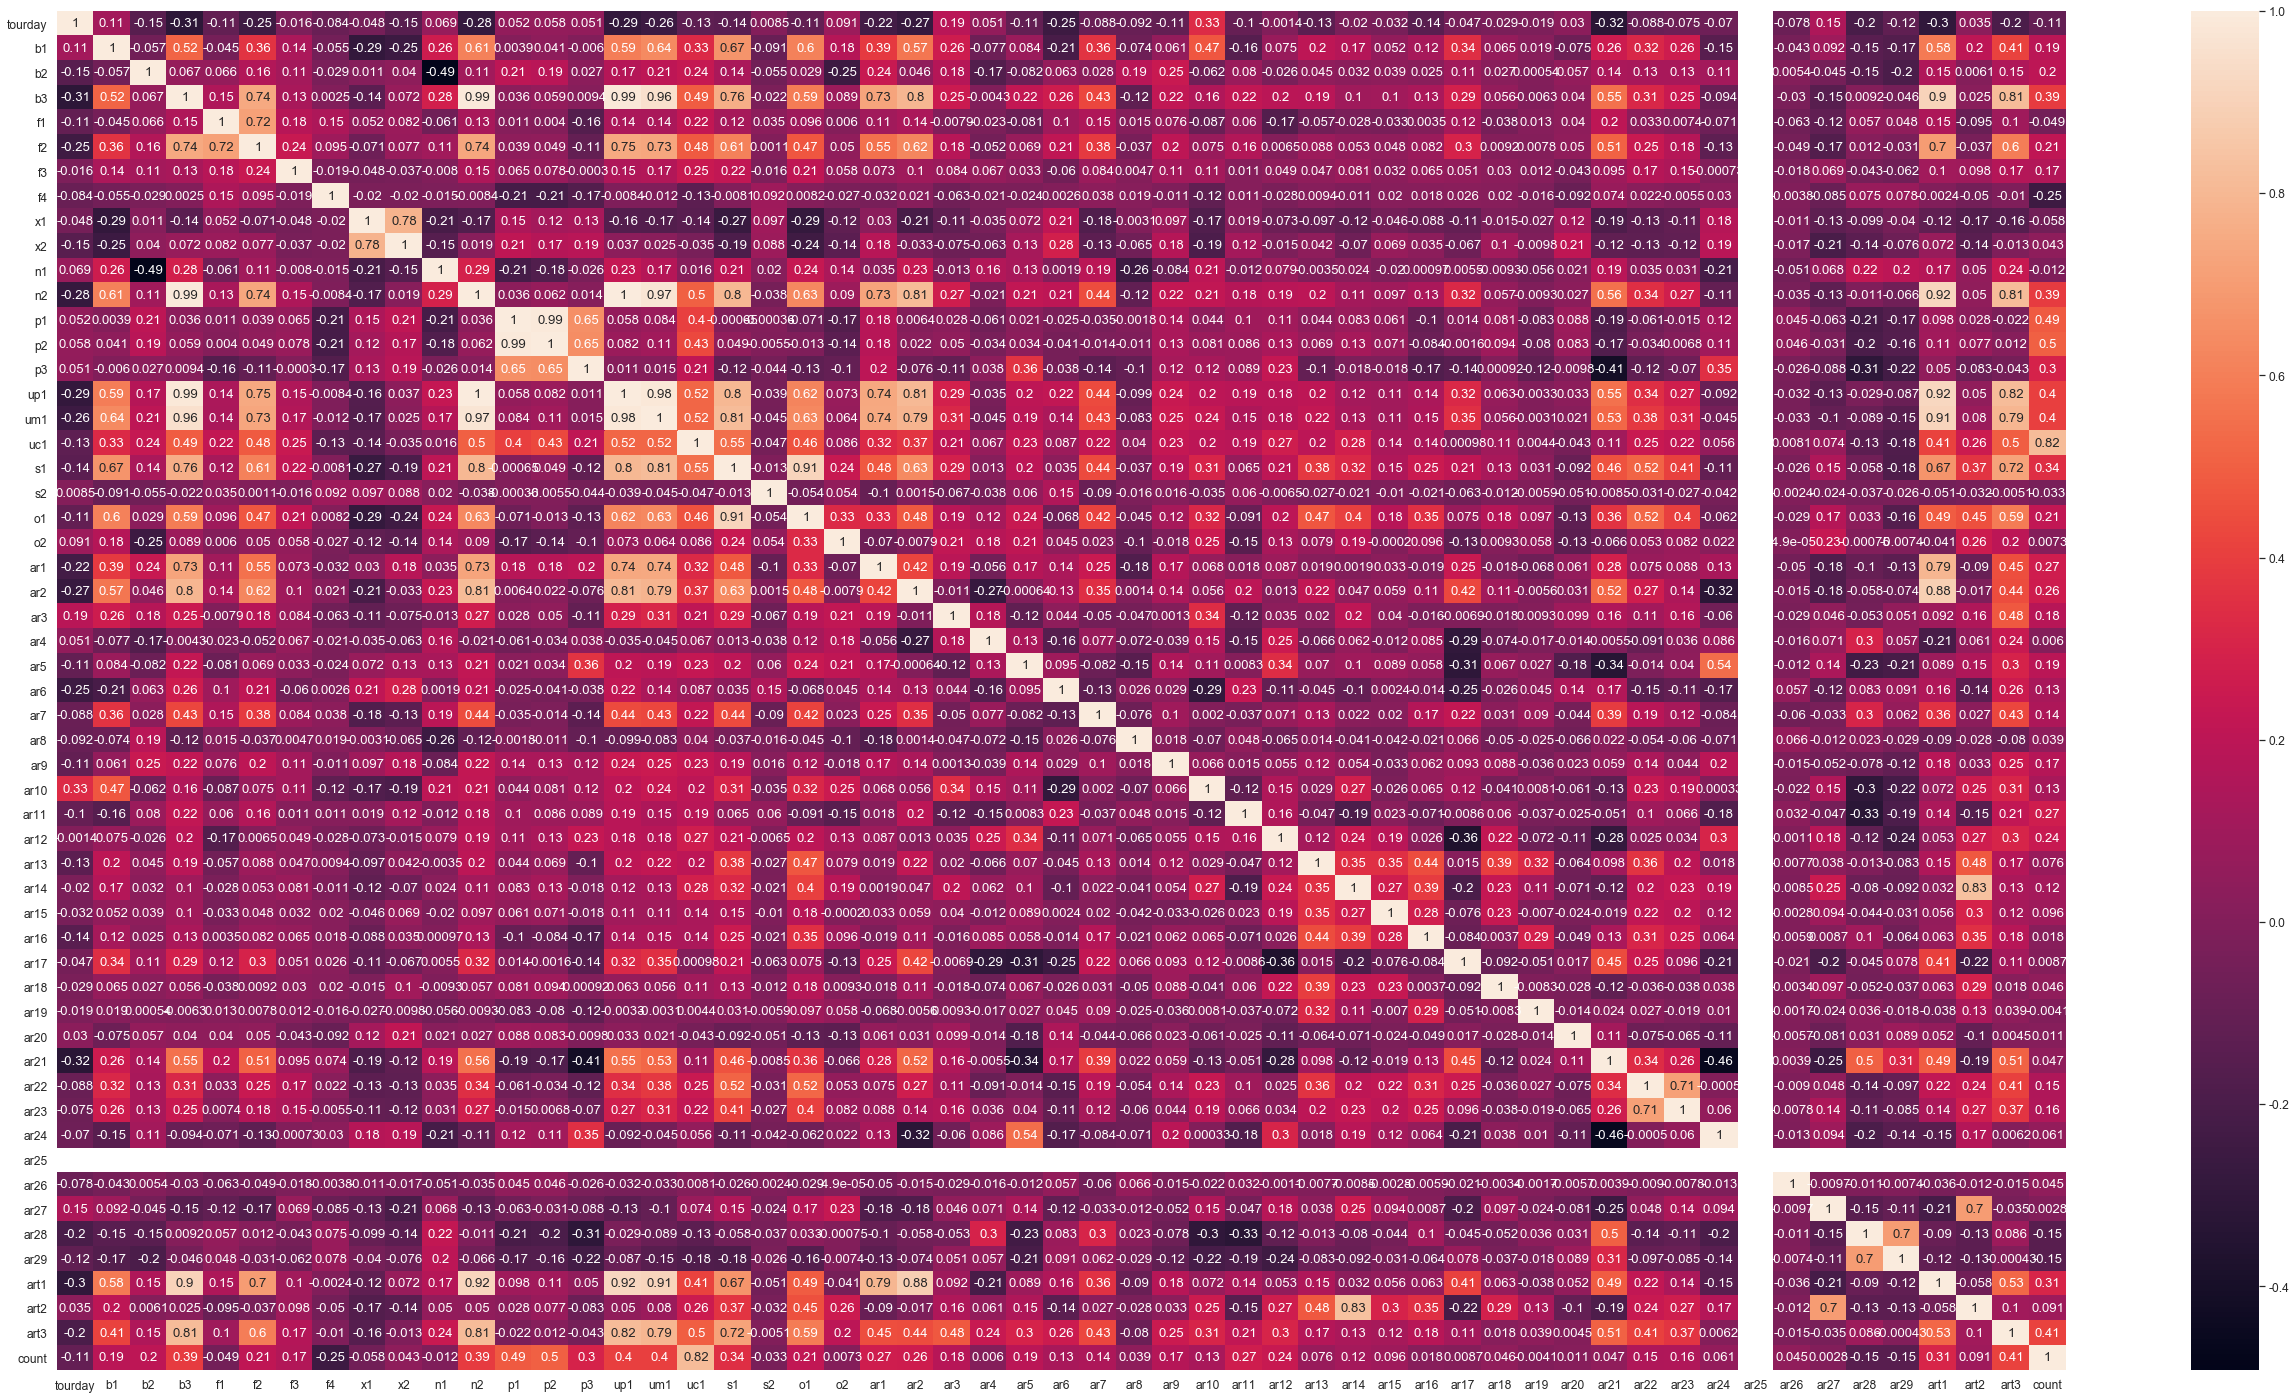

In [28]:
transformed_corr = train.corr()
plt.figure(figsize=(45,25))
sns.heatmap(transformed_corr, annot=True)

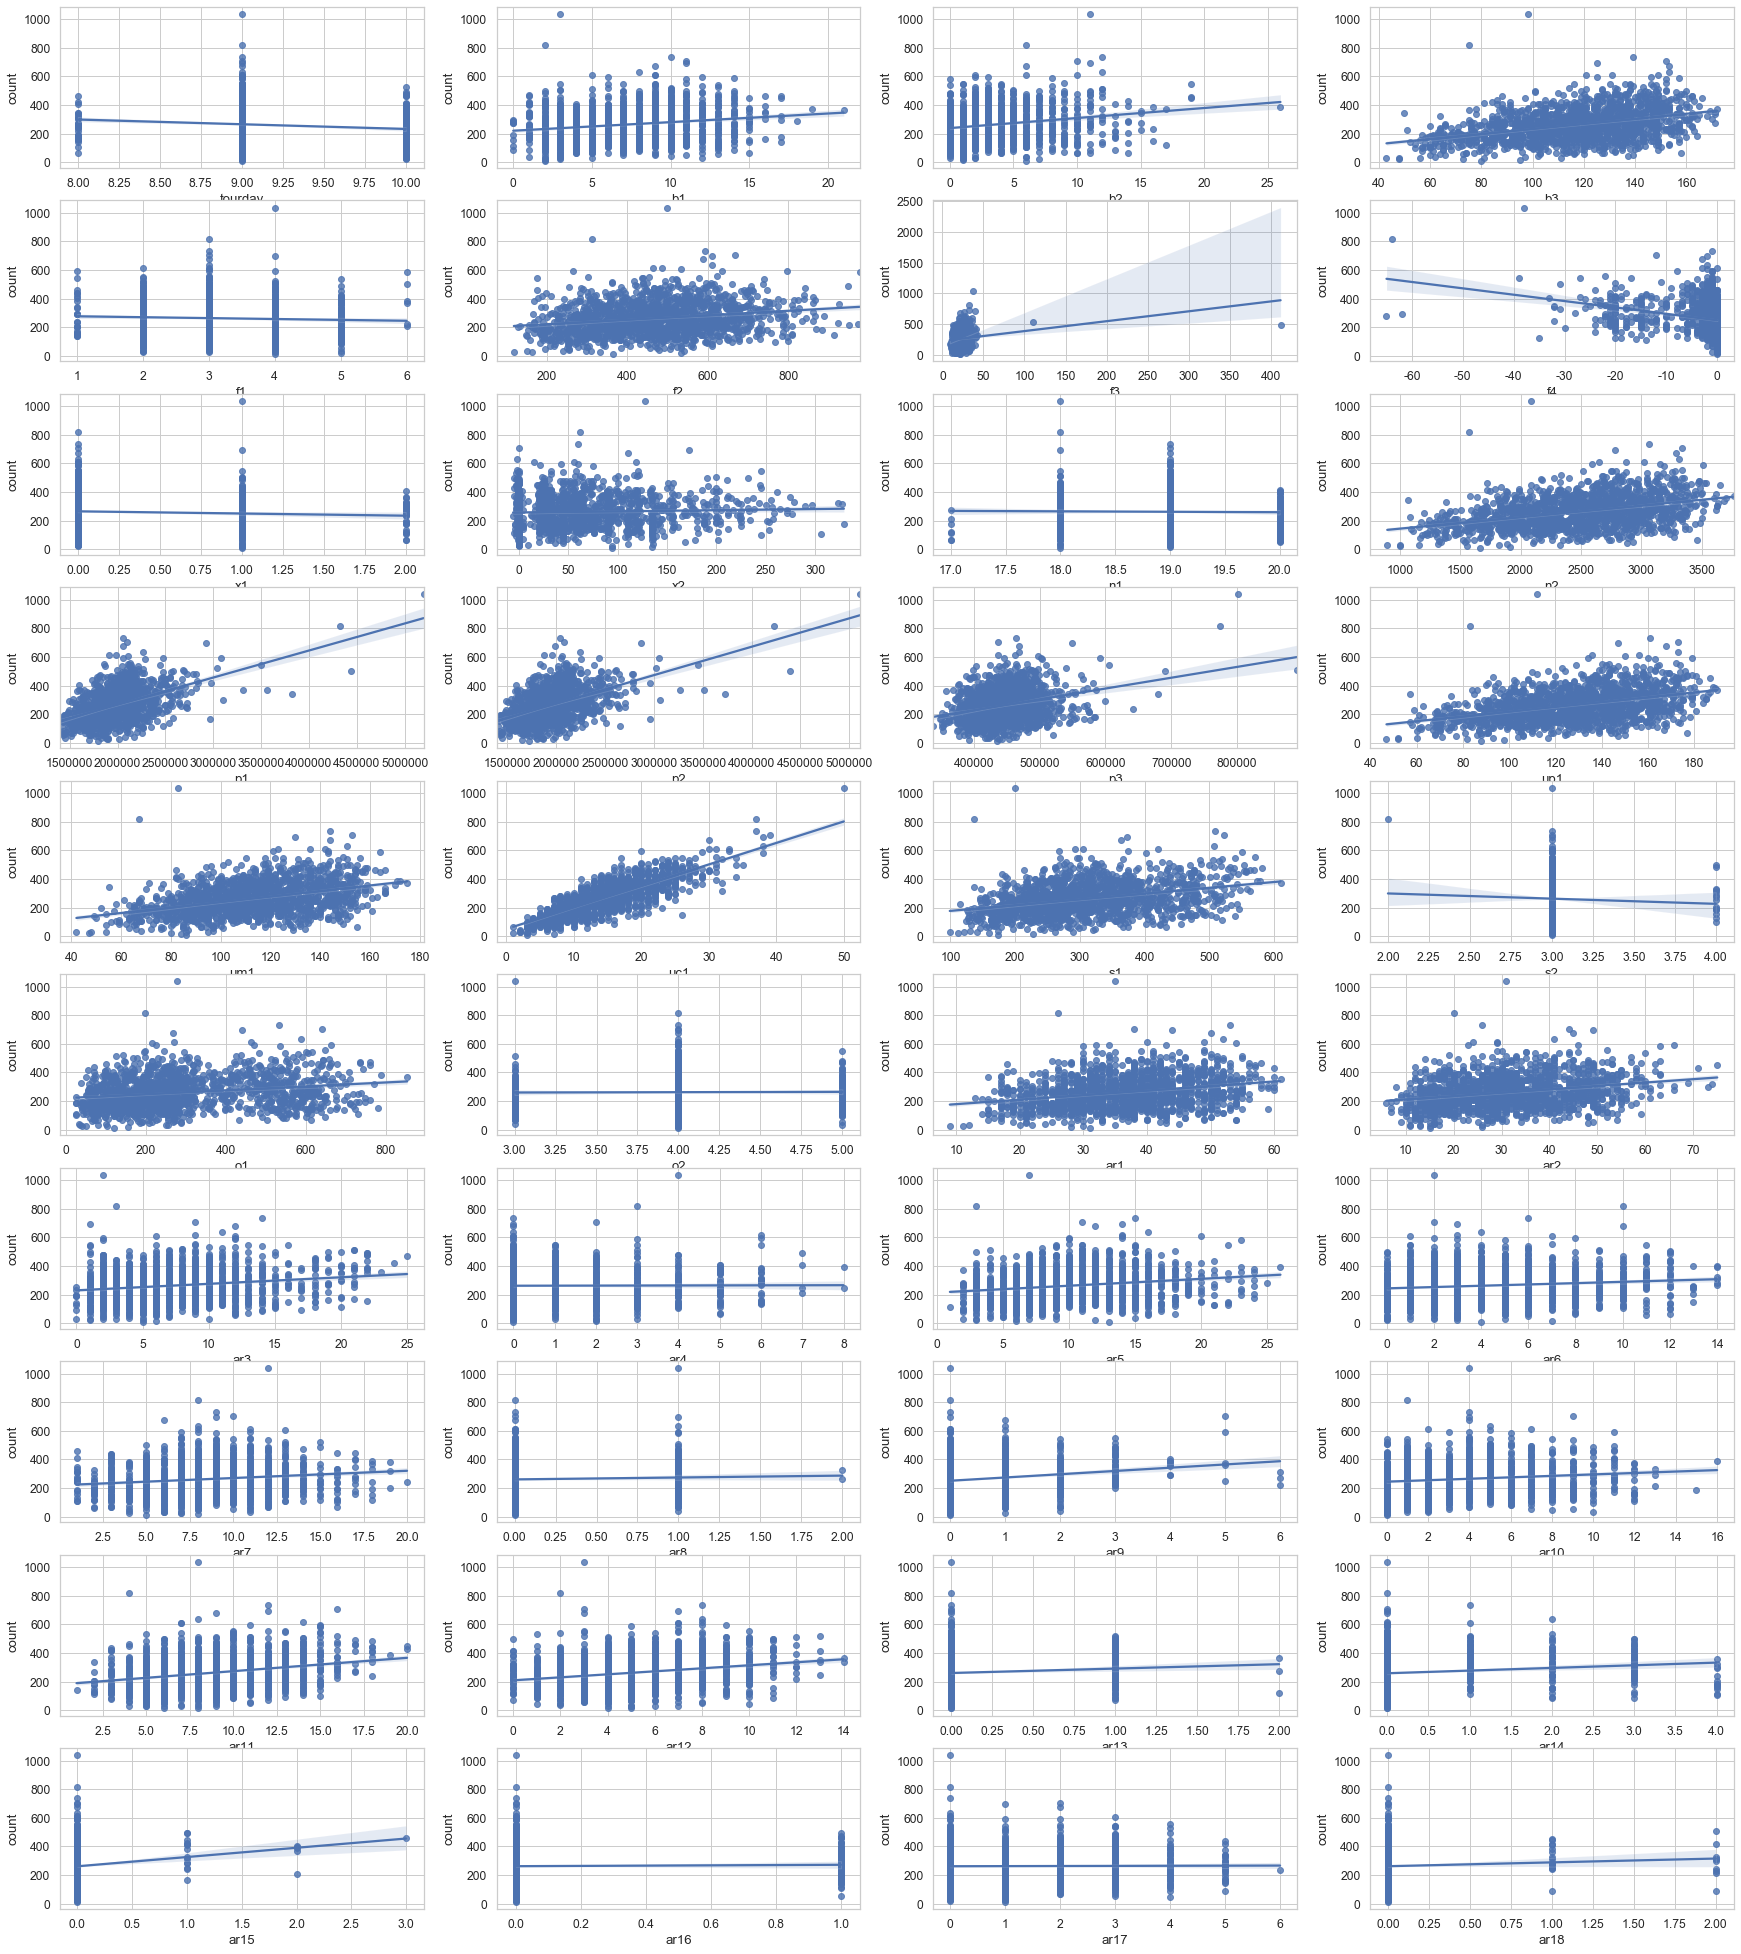

In [30]:
fig, ax = plt.subplots(10, 4, figsize=(30, 35))
for variable, subplot in zip(features, ax.flatten()):
    sns.regplot(x=train[variable], y=train['count'], ax=subplot)

In [31]:
num_col = train.select_dtypes(exclude=['object']).drop(['datetime','count'], axis=1).columns

ValueError: num must be 1 <= num <= 40, not 41

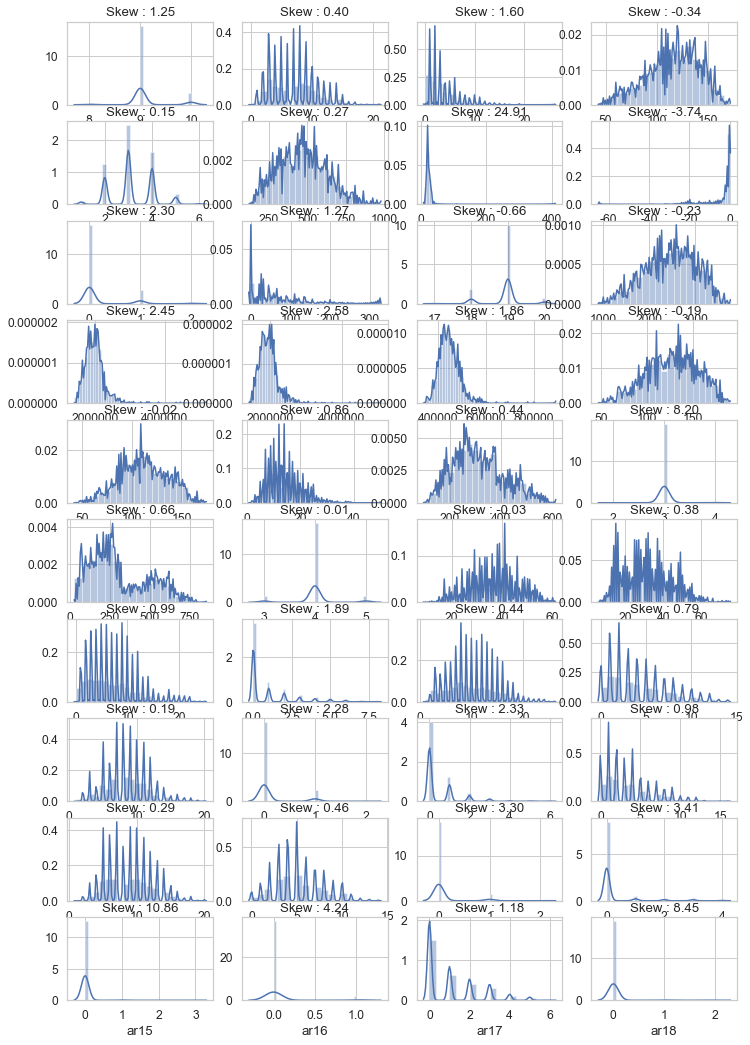

In [32]:
fig = plt.figure(figsize=(12,18))
for i in range(len(num_col)):
    fig.add_subplot(10,4,i+1)
    sns.distplot(train[num_col[i]], kde_kws={'bw': 0.1})
    plt.title('Skew : %.2f' % train[num_col[i]].skew())
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Skew : -1.03')

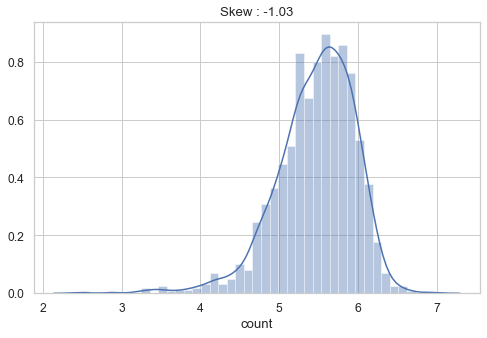

In [107]:
# Revenue with log
sns.distplot(np.log(train['count']))
plt.title('Skew : %.2f' % np.log(train['count']).skew())

ValueError: num must be 1 <= num <= 40, not 41

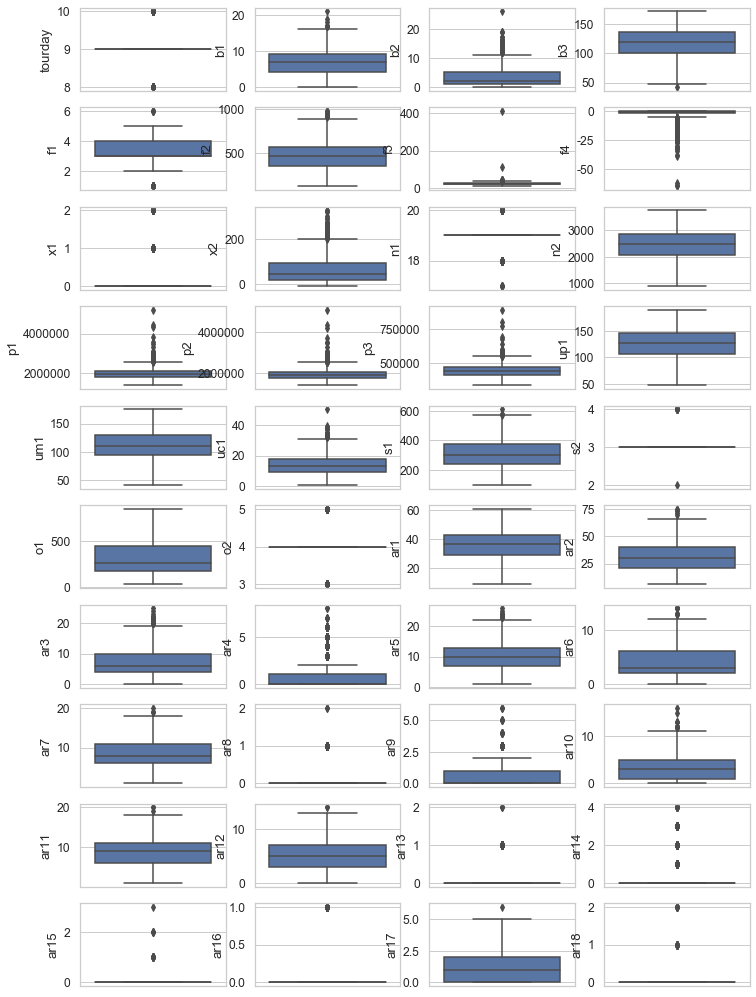

In [108]:
# Univariate analysis - boxplot
fig = plt.figure(figsize=(12,18))
for i in range(len(num_col)):
    fig.add_subplot(10,4,i+1)
    sns.boxplot(y=train[num_col[i]])
    
plt.tight_layout()
plt.show()

## 시계열 분석 진행

In [56]:
train['year']=train["datetime"].dt.year
train['month']=train["datetime"].dt.month
train['week']=train["datetime"].dt.week
train['day']=train["datetime"].dt.day
train["dayofweek"] = train["datetime"].dt.dayofweek

In [57]:
train.head()

,datetime,tourday,b1,b2,b3,f1,f2,f3,f4,x1,...,ar29,art1,art2,art3,count,year,month,week,day,dayofweek
0,2015-01-01,9,3,13,117,3,487,30,0,0,...,0,63,0,70,321,2015,1,1,1,3
1,2015-01-02,9,3,2,87,3,314,27,-1,0,...,0,49,0,43,271,2015,1,1,2,4
2,2015-01-03,8,1,5,94,3,301,14,-1,0,...,0,48,0,52,315,2015,1,1,3,5
3,2015-01-04,9,3,3,93,4,400,24,0,0,...,0,44,0,55,271,2015,1,1,4,6
4,2015-01-05,10,4,6,58,3,208,20,0,1,...,0,41,0,27,109,2015,1,2,5,0
